In [204]:
import random

import numpy as np
import matplotlib.pyplot as plt


from Project.BallOnIncline.BallOnIncline_data import *
from pathlib import Path
from iminuit import Minuit
from iminuit import cost
from scipy import stats
plt.style.use('fivethirtyeight')

In [142]:
#Measurements in mm and degree
# Setup_Base = 90.05
# Setup_Base_Sigma = 1e-3
#
# Setup_Height = 22.17
# Setup_Height_Sigma = 1e-3
#
# Ball_Diameter = {'big': 15.00, 'medium': 12.67, 'little': 10.00}
# Ball_Diameter_Sigma ={'big': 1e-3, 'medium': 1e-3, 'little': 1e-3}
#
# Rail_Spacing = 6.06
# Rail_Spacing_Sigma = 1e-3
#
# Setup_Angle = np.array([13.79,14.09])
# Setup_Angle_Sigma = 1e-2
#
# Gate_Spacing = [16.35, 34.05, 52.18, 71.21, 88.75] # entry 1 is the higest placed gate
# Gate_Spacing_Sigma = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3] # entry 1 is the higest placed gate

# finding Mean gate spacing

In [143]:
def WeigthedMean(x, sigmax):
    top = 0
    btm = 0
    for xi, si in zip(x, sigmax):
        top += xi/si**2
        btm += 1/si**2
    WeightMean = top/btm
    return WeightMean, np.sqrt(1/btm)
GateNamex = [gate1      , gate2    , gate3    , gate4    , gate5]
GateNamesig = [sig_gate1, sig_gate2, sig_gate3, sig_gate4, sig_gate5]


GateXMeans  = []
GateXSigmas = []

# for xi, si in zip(GateNamex, GateNamesig):
#     WmeanX, std = WeigthedMean(xi, si)
#     GateXMeans.append(WmeanX)
#     GateXSigmas.append(std)
for xi, si in zip(GateNamex, GateNamesig):
    WmeanX, std = [np.mean(xi), np.std(si, ddof=1)]
    GateXMeans.append(WmeanX)
    GateXSigmas.append(std)



In [144]:
def NumpyWeightedMean(Data, Sigma):
    mean_weighted_np = np.average(Data, weights = 1.0/np.array(Sigma)**2)
    error_weighted_np = np.sqrt(1.0/np.sum(1.0/np.square(Sigma)))
    return mean_weighted_np, error_weighted_np
print(f'NWeight {NumpyWeightedMean(gate1, sig_gate1)}')
print(f'NWeight {WeigthedMean(gate1, sig_gate1)}')

NWeight (np.float64(0.16310366972477064), np.float64(9.578262852211514e-05))
NWeight (0.16310366972477064, np.float64(9.578262852211514e-05))


In [145]:
def ChiSquareTestWeightedMean(Data, Sigma , Mean = 0, evalSigma = False):

    assert len(Data) == len(Sigma), 'Length of Data must be the same as the length og the uncertainties'
    if evalSigma == True:
        Sigma = np.std(Data)*np.ones(len(Data))

    Mean, err = WeigthedMean(Data, Sigma)

    ChiSquare = np.sum(np.square(np.array(Data) - Mean) / np.array(Sigma)**2)

    # print(ChiSquare)
    ChiSquareProbability = stats.chi2.sf(ChiSquare, len(Data)-1)
    return ChiSquare, ChiSquareProbability


# ChiPGate1 = ChiSquareTestWeightedMean(gate1, sig_gate1, evalSigma=False)
# ChiPGate2 = ChiSquareTestWeightedMean(gate2, sig_gate2, evalSigma=False)
# ChiPGate3 = ChiSquareTestWeightedMean(gate3, sig_gate3, evalSigma=False)
# ChiPGate4 = ChiSquareTestWeightedMean(gate4, sig_gate4, evalSigma=False)
# ChiPGate5 = ChiSquareTestWeightedMean(gate5, sig_gate5, evalSigma=False)
#
# np.column_stack((ChiPGate1, ChiPGate2, ChiPGate3, ChiPGate4, ChiPGate5))
# print(f'ChiPGate1{ChiPGate1}, ChiPGate2{ChiPGate2}, ChiPGate3{ChiPGate3}, ChiPGate4{ChiPGate4}, ChiPGate5{ChiPGate5} ')

In [146]:
def cfn(x, const):
    return np.ones_like(x)*const

def FitTest(Data, Sigma):
    c = cost.LeastSquares(np.arange(len(Data)), Data, Sigma, cfn)
    mfit = Minuit(c, const = 18.0)
    mfit.migrad()
    pval = stats.chi2.sf(mfit.fval, len(Data)-1)
    return mfit.migrad(), pval
# FitTest(gate1, sig_gate1)

In [147]:
def read_csv(filename, trim, trimend=1):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13, names=True)
    trimdat = dat[trim:-trimend]
    time = trimdat['Time_s']
    voltage = trimdat['Channel_1_V']
    return time, voltage

Text(0, 0.5, 'Voltage (V)')

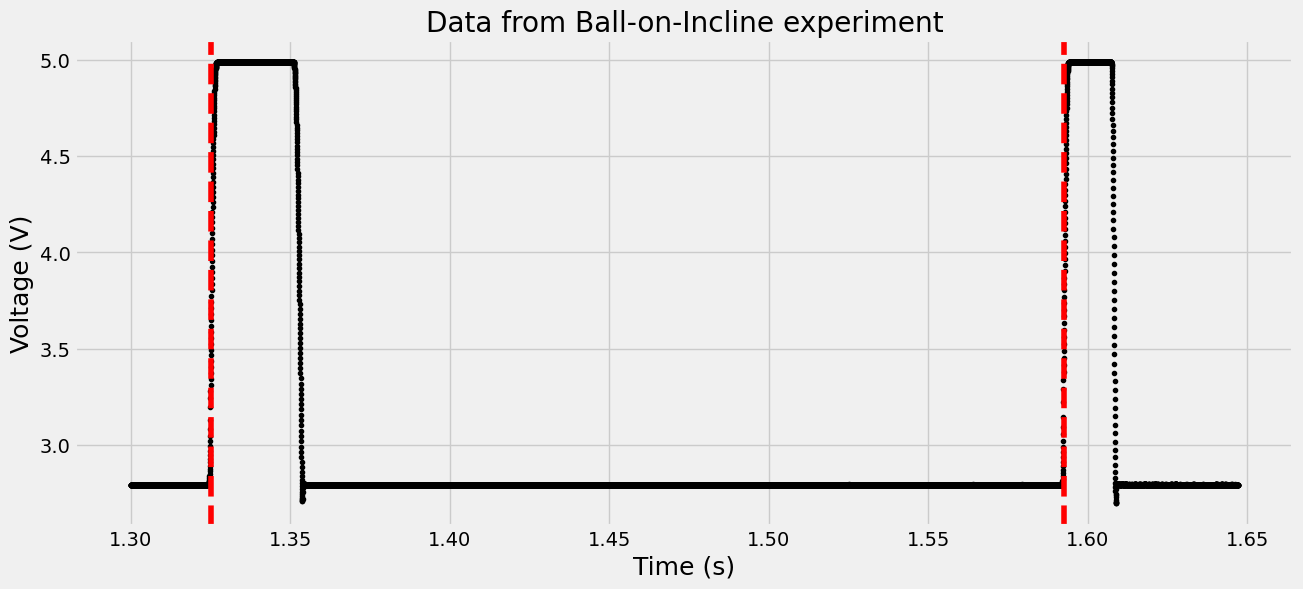

In [205]:
def find_midpoints(time, voltage):
    """Find timing of ball crossings"""
    threshold = np.mean(voltage)+ np.std(voltage)
    Transient_Mask = (voltage[:-1] < threshold) & (voltage[1:] >= threshold)
    Transient_Times = np.array(time[1:])[Transient_Mask]
    return Transient_Times, np.mean(np.diff(time))

filename = 'Waveforms_data/Big_1.csv'
# Read the data and plot it (possibly with passing times in):

trim = 90000
trimend = 99550
time, voltage = read_csv(filename, trim,trimend)

timepass, time_Sigma = find_midpoints(time, voltage)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time, voltage, 'k.', label='Measurements')
#adding a vertical line at each time the ball passes
for t in timepass:
    ax.axvline(t, color='r', linestyle='--',linewidth=4 , label='Ball pass' if t == timepass[0] else "")
ax.set_title("Data from Ball-on-Incline experiment")
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_ylabel("Voltage (V)", fontsize=18)



In [149]:
#getting the five passthrough times for each experiment
TimeArray = []
TimeSigmaArray = []
for Fi in filenames:
    Base = 'Waveforms_data'
    trim = 2000
    trimend = 2000
    Time, voltage = read_csv(Path(Base) / Fi, trim,trimend)

    if Time[0] != 0:
        Time = np.array(Time) - Time[0]
    Timepass, TimeSigma = find_midpoints(Time, voltage)

    TimeArray.append(Timepass)
    TimeSigmaArray.append(TimeSigma)

In [150]:
def Parapolic_fit(x, a ,v0, s0):
    y = 1/2*a *x**2 +v0*x+ s0
    return y

In [208]:
ParabolicFitObj = cost.LeastSquares(x = TimeArray[10], y =GateXMeans, yerror=GateXSigmas, model= Parapolic_fit)
fit = Minuit(ParabolicFitObj, a=0.6, s0 = 2, v0 = 2)
fit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.019 (χ²/ndof = 1.0)      │              Nfcn = 85               │
│ EDM = 1.65e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.381   │   0.005   │            │            │         │         │       │
│ 1 │ v0   │  -0.757   │   0.006   │            │            │         │         │       │
│ 2 │ s0   │   0.303   │   0.004   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │         a        v0        s0 │
├────┼───────────────────────────────┤
│  a │  2.67e-05 -0.033e-3  0.020e-3 │
│ v0 │ -0.033e-3   4.2e-05 -0.025e-3 │
│ s0 │  0.020e-3 -0.025e-3  1.53e-05 │
└────┴───────────────────────────────┘

Text(0, 0.5, 'Ball position (m)')

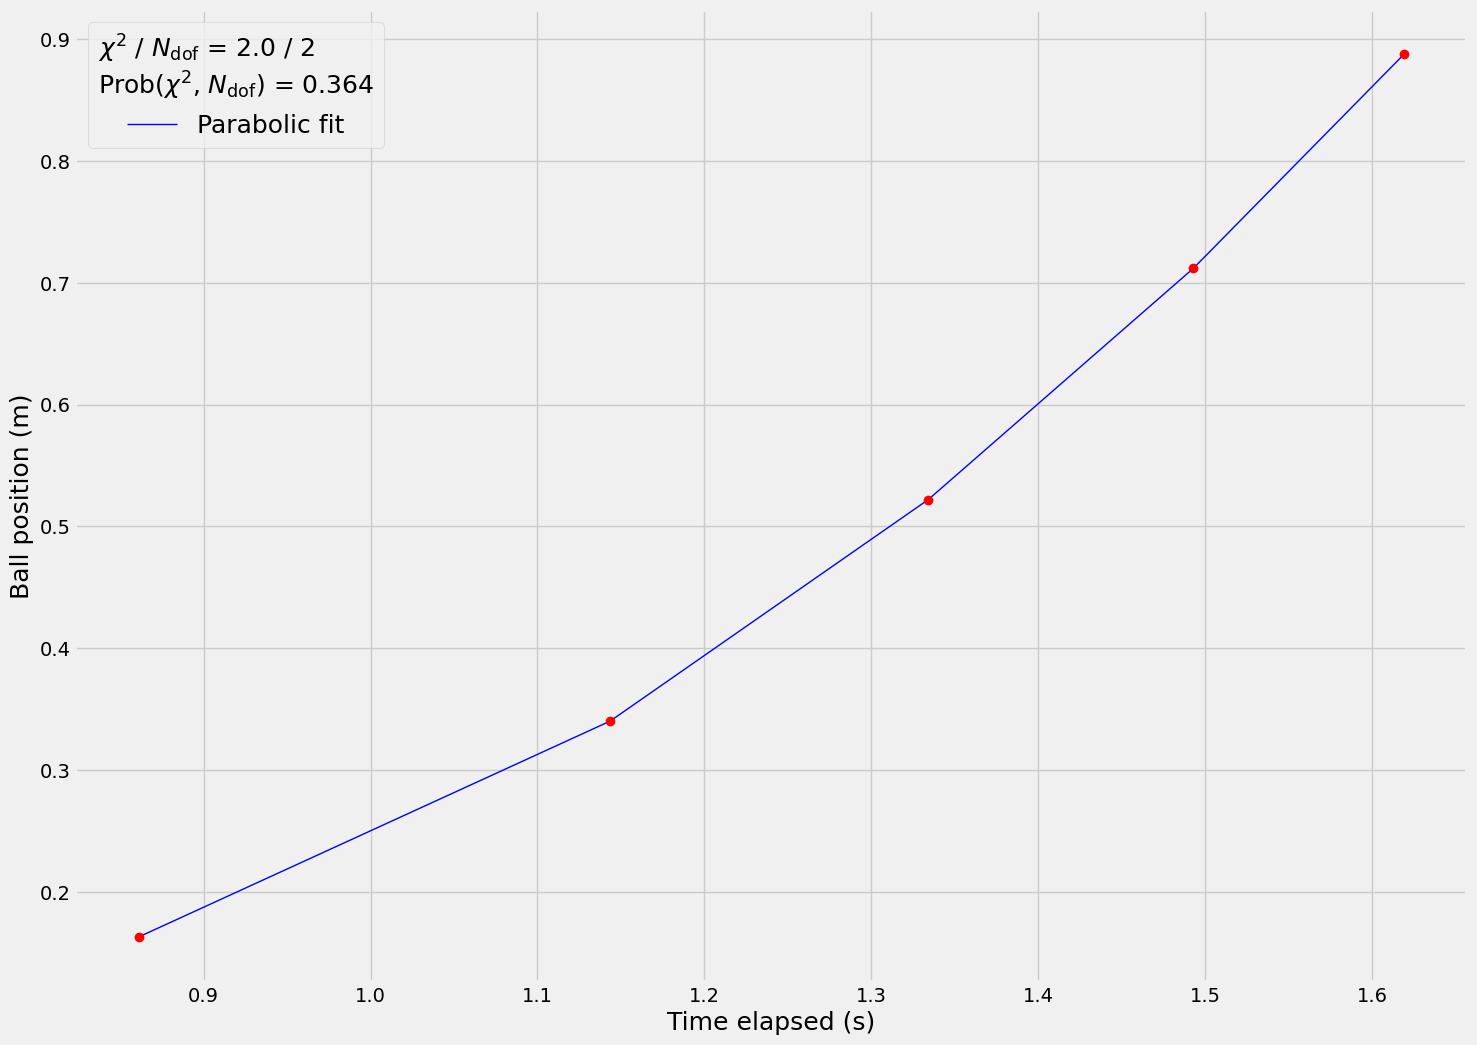

In [224]:
# Plotting
n = 10
sig_t = 0.1     # Set your own values...
Prob = stats.chi2.sf(fit.fval, 2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))
ax.errorbar(TimeArray[n], Parapolic_fit(TimeArray[n], *fit.values ), yerr=GateXSigmas, color='r', fmt='o')
ax.plot(TimeArray[n], Parapolic_fit(TimeArray[n], *fit.values ), label = 'Parabolic fit', color='b', linewidth=1)
plot_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {fit.fval:.2f} / {2}", f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {Prob:.3f}",]
ax.legend(title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center')
ax.set_xlabel('Time elapsed (s)', fontsize=18)
ax.set_ylabel('Ball position (m)', fontsize=18)

In [215]:
fit.fval

2.01929664142748

In [152]:
AccelerationValueArray = []
AccelerationSigmaArray = []

for TArri in TimeArray:
    ParabolicFitObj = cost.LeastSquares(x = TArri, y = GateXMeans, yerror = GateXSigmas, model = Parapolic_fit)
    fiti = Minuit(ParabolicFitObj, a=0.5,v0 = 2, s0 = 2)
    fiti.migrad()
    AccelerationValueArray.append(fiti.values[0])
    AccelerationSigmaArray.append(fiti.errors[0])


AccelerationValueArray = np.array(AccelerationValueArray)
AccelerationSigmaArray = np.array(AccelerationSigmaArray)
AccelerationsArray = np.column_stack((AccelerationValueArray, AccelerationSigmaArray))

ForwardAccelerationValues = AccelerationsArray[::2, :]
ReverseAccelerationValues = AccelerationsArray[1::2,:]

ForwardAccelerationValuesBig = ForwardAccelerationValues[:4]
ReverseAccelerationValuesBig = ReverseAccelerationValues[:4]

ForwardAccelerationValuesSmall = ForwardAccelerationValues[4:8]
ReverseAccelerationValuesSmall = ReverseAccelerationValues[4:8]

ForwardAccelerationValuesMedium = ForwardAccelerationValues[8:12]
ReverseAccelerationValuesMedium = ReverseAccelerationValues[8:12]



In [153]:
# Using a normal mean with a std
ForwardAccelerationBig = np.array([np.mean(ForwardAccelerationValuesBig[:,0]),np.std(ForwardAccelerationValuesBig[:,1] )])
ForwardAccelerationMedium = np.array([np.mean(ForwardAccelerationValuesMedium[:,0]),np.std(ForwardAccelerationValuesMedium[:,1] )])
ForwardAccelerationSmall = np.array([np.mean(ForwardAccelerationValuesSmall[:,0]),np.std(ForwardAccelerationValuesSmall[:,1] )])

ReverseAccelerationBig = np.array([np.mean(ReverseAccelerationValuesBig[:,0]),np.std(ReverseAccelerationValuesBig[:,1] )])
ReverseAccelerationMedium = np.array([np.mean(ReverseAccelerationValuesMedium[:,0]),np.std(ReverseAccelerationValuesMedium[:,1] )])
ReverseAccelerationSmall = np.array([np.mean(ReverseAccelerationValuesSmall[:,0]),np.std(ReverseAccelerationValuesSmall[:,1] )])

print(f'Forward Acceleration big {ForwardAccelerationBig[0]}+- {ForwardAccelerationBig[1]}')
print(f'Forward Acceleration Medium {ForwardAccelerationMedium[0]}+- {ForwardAccelerationMedium[1]}')
print(f'Forward Acceleration Small {ForwardAccelerationSmall[0]}+- {ForwardAccelerationSmall[1]}')

Forward Acceleration big 1.537713537302488+- 1.2194465292952514e-05
Forward Acceleration Medium 1.483521339147365+- 1.4077330502293325e-05
Forward Acceleration Small 1.38150110416805+- 1.7005093739682954e-05


In [154]:
# #Using the weighted mean with estimated uncertainties
#
# ForwardAccelerationBig = WeigthedMean(ForwardAccelerationValuesBig[:,0], ForwardAccelerationValuesBig[:,1] )
# ForwardAccelerationMedium = WeigthedMean(ForwardAccelerationValuesMedium[:,0], ForwardAccelerationValuesMedium[:,1] )
# ForwardAccelerationSmall = WeigthedMean(ForwardAccelerationValuesSmall[:,0], ForwardAccelerationValuesSmall[:,1] )
#
# FABChiP = ChiSquareTestWeightedMean(ForwardAccelerationValuesBig[:,0], ForwardAccelerationValuesBig[:,1])
# FAMChiP = ChiSquareTestWeightedMean(ForwardAccelerationValuesMedium[:,0], ForwardAccelerationValuesMedium[:,1])
# FASChiP = ChiSquareTestWeightedMean(ForwardAccelerationValuesSmall[:,0], ForwardAccelerationValuesSmall[:,1])
#
# print(f'Forward Acceleration big {ForwardAccelerationBig[0]}+- {ForwardAccelerationBig[1]}')
# print(f'Forward Acceleration Medium {ForwardAccelerationMedium[0]}+- {ForwardAccelerationMedium[1]}')
# print(f'Forward Acceleration Small {ForwardAccelerationSmall[0]}+- {ForwardAccelerationSmall[1]}')
# np.column_stack((FABChiP, FAMChiP, FASChiP))

In [155]:
# ReverseAccelerationBig = WeigthedMean(ReverseAccelerationValuesBig[:,0],ReverseAccelerationValuesBig[:,1] )
# ReverseAccelerationMedium = WeigthedMean(ReverseAccelerationValuesMedium[:,0],ReverseAccelerationValuesMedium[:,1] )
# ReverseAccelerationSmall = WeigthedMean(ReverseAccelerationValuesSmall[:,0],ReverseAccelerationValuesSmall[:,1] )
#
# RABChiP = ChiSquareTestWeightedMean(ReverseAccelerationValuesBig[:,0], ReverseAccelerationValuesBig[:,1])
# RAMChiP = ChiSquareTestWeightedMean(ReverseAccelerationValuesMedium[:,0], ReverseAccelerationValuesMedium[:,1])
# RASChiP = ChiSquareTestWeightedMean(ReverseAccelerationValuesSmall[:,0], ReverseAccelerationValuesSmall[:,1])
#
# print(f'Forward Acceleration big    {ReverseAccelerationBig[0]}+- {ReverseAccelerationBig[1]}')
# print(f'Forward Acceleration Medium {ReverseAccelerationMedium[0]}+- {ReverseAccelerationMedium[1]}')
# print(f'Forward Acceleration Small  {ReverseAccelerationSmall[0]}+- {ReverseAccelerationSmall[1]}')
# np.column_stack((RABChiP, RAMChiP, RASChiP))

# Now to calculate the other things neccecary to convert the ball acceleration into g

In [156]:
# # Cell using the Weighted Means
#
# DSmallBall = WeigthedMean(ballS_d, sig_ballS_d)
# ChiPDSmallBall = ChiSquareTestWeightedMean(ballS_d, sig_ballS_d)
#
# DMediumBall = WeigthedMean(ballM_d, sig_ballM_d)
# ChiPDMediumBall = ChiSquareTestWeightedMean(ballM_d, sig_ballM_d)
#
# DLargeBall = WeigthedMean(ballL_d, sig_ballL_d)
# ChiPDLargeBall = ChiSquareTestWeightedMean(ballL_d, sig_ballL_d)
#
# RailSpacing = WeigthedMean(rail_width, sig_rail_width)
# ChiPRailSpacing = ChiSquareTestWeightedMean(rail_width, sig_rail_width)
#
# baseLength = WeigthedMean(base, sig_base)
# ChiPBaseLength = ChiSquareTestWeightedMean(base, sig_base)
# Height = WeigthedMean(height, sig_height)
# CHiPHeight = ChiSquareTestWeightedMean(height, sig_height)
#
# RailAngle1 = WeigthedMean(rail_angle1, sig_rail_angle1)
# CHiPAngle1 = ChiSquareTestWeightedMean(rail_angle1, sig_rail_angle1)
# RailAngle2 = WeigthedMean(rail_angle2, sig_rail_angle2)
# CHiPAngle2 = ChiSquareTestWeightedMean(rail_angle2, sig_rail_angle2)


In [157]:
# print('P - values for weighted means')
# print(f'ChiPDsmallBall{ChiPDSmallBall[1]:.3f},ChiPDMediumBall{ChiPDMediumBall[1]:.3f}, ChiPDLargeBall{ChiPDLargeBall[1]:.3f}')
# print(f'RailSpacing{ChiPRailSpacing[1]:.3f},baseLength{ChiPBaseLength[1]:.3f}, Height{CHiPHeight[1]:.3f}')
# print(f'RailAngle1 {CHiPAngle1[1]:.3f}, RailAngle2 {CHiPAngle2[1]:.3f}')

In [158]:
# Cell using normal mean and std
DSmallBall = np.array([np.mean(ballS_d) ,np.std(sig_ballS_d)])
DMediumBall = np.array([np.mean(ballM_d) ,np.std(sig_ballM_d)])
DLargeBall = np.array([np.mean(ballL_d), np.std(sig_ballL_d)])

RailSpacing = np.array([np.mean(rail_width),np.std(sig_rail_width)])
baseLength = np.array([np.mean(base), np.std(sig_base)])
Height = np.array([np.mean(height), np.std(sig_height)])

RailAngle1 = np.array([np.mean(rail_angle1),np.std( sig_rail_angle1)])
RailAngle2 = np.array([np.mean(rail_angle2),np.std( sig_rail_angle2)])

In [159]:
ang = np.array([np.arctan(Height[0]/baseLength[0]), np.sqrt((1/(baseLength[0]*(1 + (Height[0]/baseLength[0]))))**2 *Height[1]**2 + (((Height[0])/(baseLength[0]**2))/(1 + (Height[0]/baseLength[0])**2))**2 * baseLength[1]**2 )])
ang

array([0.24216796, 0.00031468])

In [160]:
np.sqrt((1/(baseLength[0]*(1 + (Height[0]/baseLength[0]))))**2 *Height[1]**2 + (((Height[0])/(baseLength[0]**2))/(1 + (Height[0]/baseLength[0])**2))**2 * baseLength[1]**2 )

np.float64(0.00031468079600414196)

In [161]:
#testing estimated uncertainties against using standard deviation/ things should be gaussian but low statistics
# meanDsmall = np.mean(ballS_d)
# sigDsmall = np.std(ballS_d)
# print(f'WeightMean{DSmallBall[0]:.3e}, Mean = {meanDsmall:.3e}')
# print(f'WeightMean{DSmallBall[1]:.3e}, Mean = {sigDsmall:.3e}')

In [162]:
# and using the gravitational acceleration
def GetDeltaTheta(Angle, ForwardA, ReverseA):
    DeltaAngleAcceleration = (ForwardA-ReverseA)/(ForwardA+ReverseA) * np.tan(Angle)
    return DeltaAngleAcceleration

def SigmaDAngle(SigmaaForward, SigmaaReverse,SigmaAngle ,aForward, aReverse, Angle):
    coeff1 = ((1/(aForward + aReverse) - (aForward-aReverse)/(aForward+aReverse)**2)*np.tan(Angle))**2
    coeff2 = ((1/(aForward + aReverse) + (aForward-aReverse)/(aForward+aReverse)**2)*np.tan(Angle))**2
    SigmaDAngle = coeff1 *SigmaaForward**2 + coeff2*SigmaaReverse**2 + ((aForward-aReverse)/(aForward+aReverse)*1/np.cos(Angle)**2)**2 * SigmaAngle**2
    return SigmaDAngle


DThSmall = GetDeltaTheta(ang[0], ForwardAccelerationSmall[0], ReverseAccelerationSmall[0])
DThMedium = GetDeltaTheta(ang[0], ForwardAccelerationMedium[0], ReverseAccelerationMedium[0])
DThBig = GetDeltaTheta(ang[0], ForwardAccelerationBig[0], ReverseAccelerationBig[0])

SigmaDAngleSmall  = SigmaDAngle(ForwardAccelerationSmall[1], ReverseAccelerationSmall[1], ang[1], ForwardAccelerationSmall[0], ReverseAccelerationSmall[0], ang[0])
SigmaDAngleMedium = SigmaDAngle(ForwardAccelerationMedium[1], ReverseAccelerationMedium[1], ang[1], ForwardAccelerationMedium[0], ReverseAccelerationMedium[0], ang[0])
SigmaDAngleBig    = SigmaDAngle(ForwardAccelerationBig[1], ReverseAccelerationBig[1], ang[1], ForwardAccelerationBig[0], ReverseAccelerationBig[0], ang[0])


np.vstack((DThSmall, DThMedium, DThBig))*180/np.pi

array([[-0.00541904],
       [-0.03778026],
       [-0.01103195]])

In [163]:
DeltaAngleGoniometer = RailAngle1[0]- RailAngle2[0]
DeltaAngleGoniometer/2

np.float64(0.06874999999999964)

## Quick calculation of g, needs a lot of statistics to be done


In [164]:
def CalculateGravitationalAcceleration(aForward, aReverse, Angle, dAngle, Dball, drail):
    gForward = aForward/np.sin((Angle+dAngle))*(1 + 2/5 * Dball**2/(Dball**2 - drail**2))
    gReverse = aReverse/np.sin((Angle-dAngle))*(1 + 2/5 * Dball**2/(Dball**2 - drail**2))
    return np.array([gForward,gReverse])

Big_g = CalculateGravitationalAcceleration(ForwardAccelerationBig[0], ReverseAccelerationBig[0],  ang[0]  , DThBig , DLargeBall[0], RailSpacing[0] )
Medium_g = CalculateGravitationalAcceleration(ForwardAccelerationMedium[0], ReverseAccelerationMedium[0],  ang[0]  , DThMedium , DMediumBall[0], RailSpacing[0] )
Little_g = CalculateGravitationalAcceleration(ReverseAccelerationSmall[0], ReverseAccelerationSmall[0],  ang[0]  , DThSmall , DSmallBall[0], RailSpacing[0] )
np.vstack((Big_g,Medium_g, Little_g))

array([[9.47185996, 9.47185996],
       [9.3960555 , 9.3960555 ],
       [9.37115307, 9.36397955]])

## Propagating errors

In [170]:
def SigmaGFromA(SigA, DB, Angle, DAngle, drail):
    SigG = (1 + 2/5 * DB**2/(DB**2 - drail**2))/np.sin(Angle + DAngle)*SigA**2
    return np.sqrt(SigG)

def SigmaGFromDB(SigDB, DB, a, Angle, DAngle, drail):
    SigG = ((2*a)/(5*np.sin(Angle + DAngle))*((2*DB)/(DB**2 - drail**2) - (2*DB**3)/(DB**2 - drail**2)))**2 * SigDB**2
    return np.sqrt(SigG)

def SigmaGFromdrail(Sigdrail, DB, a, Angle, DAngle, drail):
    SigG = ((4*a)/(5*np.sin(Angle + DAngle))* (drail*DB**2)/(DB**2 - drail**2))**2 * Sigdrail**2
    return np.sqrt(SigG)

def SigmaGFromAngle(SigAngle, DB, a, Angle, DAngle, drail):
    SigG = (-(a*np.cos(Angle+DAngle))/np.sin(Angle+DAngle)**2*(1 + 2/5 * (DB**2)/(DB**2 - drail**2)))**2 * SigAngle**2
    return np.sqrt(SigG)

def SigmaGFromDAngle(SigDAngle, DB, a, Angle, DAngle, drail):
    SigG = (-(a*np.cos(Angle+DAngle))/np.sin(Angle+DAngle)**2*(1 + 2/5 * (DB**2)/(DB**2 - drail**2)))**2 * SigDAngle**2
    return np.sqrt(SigG)

def SigmaG(sigmas, par):
    SigA, SigDB, Sigdrail, SigAngle, SigDAngle = sigmas
    a, DB, drail , Angle, DAngle = par

    SA = SigmaGFromA(SigA, DB, Angle, DAngle, drail)
    SDB = SigmaGFromDB(SigDB, DB, a, Angle, DAngle, drail)
    Sdrail = SigmaGFromdrail(Sigdrail, DB, a, Angle, DAngle, drail)
    SAng = SigmaGFromAngle(SigAngle, DB, a, Angle, DAngle, drail)
    SDAng = SigmaGFromDAngle(SigDAngle, DB, a, Angle, DAngle, drail)
    Sigg = [SA, SDB, Sdrail, SAng, SDAng]
    return Sigg

Forward_sigma_Small = (ForwardAccelerationSmall[1], DSmallBall[1], RailSpacing[1], ang[1] , SigmaDAngleSmall )
Forward_par_small = (ForwardAccelerationSmall[0], DSmallBall[0], RailSpacing[0], ang[0], DThSmall)

Forward_sigma_Medium = (ForwardAccelerationMedium[1], DMediumBall[1], RailSpacing[1], ang[1] , SigmaDAngleMedium )
Forward_par_Medium = (ForwardAccelerationMedium[0], DMediumBall[0], RailSpacing[0], ang[0], DThMedium)

Forward_sigma_Large = (ForwardAccelerationBig[1], DLargeBall[1], RailSpacing[1], ang[1] , SigmaDAngleBig )
Forward_par_Large = (ForwardAccelerationBig[0], DLargeBall[0], RailSpacing[0], ang[0], DThBig)

Forward_SmallGSigma = np.sum(SigmaG(Forward_sigma_Small, Forward_par_small))
Forward_MediumGSigma = np.sum(SigmaG(Forward_sigma_Medium, Forward_par_Medium))
Forward_BigGSigma = np.sum(SigmaG(Forward_sigma_Large, Forward_par_Large))

Reverse_sigma_Small = (ReverseAccelerationSmall[1], DSmallBall[1], RailSpacing[1], ang[1] , SigmaDAngleSmall )
Reverse_par_small = (ReverseAccelerationSmall[0], DSmallBall[0], RailSpacing[0], ang[0], DThSmall)

Reverse_sigma_Medium = (ReverseAccelerationMedium[1], DMediumBall[1], RailSpacing[1], ang[1] , SigmaDAngleMedium )
Reverse_par_Medium = (ReverseAccelerationMedium[0], DMediumBall[0], RailSpacing[0], ang[0], DThMedium)

Reverse_sigma_Large = (ReverseAccelerationBig[1], DLargeBall[1], RailSpacing[1], ang[1] , SigmaDAngleBig )
Reverse_par_Large = (ReverseAccelerationBig[0], DLargeBall[0], RailSpacing[0], ang[0], DThBig)

Reverse_SmallGSigma = np.sum(SigmaG(Reverse_sigma_Small, Reverse_par_small))
Reverse_MediumGSigma = np.sum(SigmaG(Reverse_sigma_Medium, Reverse_par_Medium))
Reverse_BigGSigma = np.sum(SigmaG(Reverse_sigma_Large, Reverse_par_Large))

SmallSigmag = np.array([Forward_SmallGSigma, Reverse_SmallGSigma])
MediumSigmag = np.array([Forward_MediumGSigma, Reverse_MediumGSigma])
BigSigmag = np.array([Forward_BigGSigma, Reverse_BigGSigma])
SIgg = np.concatenate(np.vstack((SmallSigmag, MediumSigmag, BigSigmag)))
SIgg

array([0.15672618, 0.15683758, 0.11308364, 0.11369346, 0.09388883,
       0.09404291])

In [209]:
SigmaG(Forward_sigma_Small, Forward_par_small)

[np.float64(4.4272458593485356e-05),
 np.float64(0.1447393357697966),
 np.float64(8.665696028639283e-06),
 np.float64(0.011933905178215513),
 np.float64(1.4500008753054684e-10)]

In [173]:
np.sqrt(1/np.sum(1/SIgg))

np.float64(0.1391043831505628)

In [177]:
gArray = np.concatenate((np.vstack((Big_g, Medium_g, Little_g))))
G = [np.average(gArray, weights=(1/SIgg**2)), np.sqrt(1/np.sum(1/SIgg**2))]


[np.float64(9.395442775131588), np.float64(0.046451978915029744)]

In [178]:
(9.81-G[0])/G[1]

np.float64(8.92442549383575)

In [174]:
NumpyWeightedMean(gArray, SIgg)

(np.float64(9.395442775131588), np.float64(0.046451978915029744))

## Pendul eksperiment

In [168]:
Pendulum_Height_from_floor = 67.45 #cm
top = 58.95# cm
start = 56.00 #cm
Pendulum_height = top - start

Pendulum_Period = []
Time = []

Pendulum_height

2.950000000000003